In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import r2_score

%matplotlib inline

In [2]:
f = h5py.File('matlab_strf.h5', 'r')

In [3]:
n_electrodes = len(f)
n_frames, n_features = f['Wave1/strf'].shape
n_train_samples = f['Wave1/train_resp'].size
n_test_samples = f['Wave1/test_resp'].size

In [4]:
strfs = np.zeros((n_electrodes, n_features, n_frames))
train_resps = np.zeros((n_electrodes, n_train_samples))
test_resps = np.zeros((n_electrodes, n_test_samples))

In [5]:
train_stim = f['Wave1/train_stim'][:]
test_stim = f['Wave1/test_stim'][:]

In [6]:
for electrode in range(n_electrodes):
    group_name = 'Wave' + str(electrode + 1)
    group = f[group_name]
    strfs[electrode] = group['strf'][:].T
    train_resps[electrode] = group['train_resp'][:].ravel()
    test_resps[electrode] = group['test_resp'][:].ravel()

In [7]:
train_stim -= train_stim.mean(axis=0, keepdims=True)
test_stim -= test_stim.mean(axis=0, keepdims=True)

In [8]:
train_resp_ests = np.zeros((n_electrodes, n_train_samples))
train_scores = np.zeros(n_electrodes)
test_resp_ests = np.zeros((n_electrodes, n_test_samples))
test_scores = np.zeros(n_electrodes)

In [9]:
for electrode in range(n_electrodes):
    y_pred_train = np.zeros(n_train_samples)
    y_pred_test = np.zeros(n_test_samples)

    for frame in range(n_frames):
        response_contribution_train = np.dot(train_stim, strfs[electrode][:, frame])
        response_contribution_test = np.dot(test_stim, strfs[electrode][:, frame])

        if frame == 0:
            y_pred_train[frame:] += response_contribution_train
            y_pred_test[frame:] += response_contribution_test
        else:
            y_pred_train[frame:] += response_contribution_train[:-frame]
            y_pred_test[frame:] += response_contribution_test[:-frame]
    
    train_resp_ests[electrode] = np.copy(y_pred_train)
    test_resp_ests[electrode] = np.copy(y_pred_test)
    train_scores[electrode] = r2_score(train_resps[electrode][n_frames-1:], y_pred_train[n_frames-1:])
    test_scores[electrode] =  r2_score(test_resps[electrode][n_frames-1:], y_pred_test[n_frames-1:])

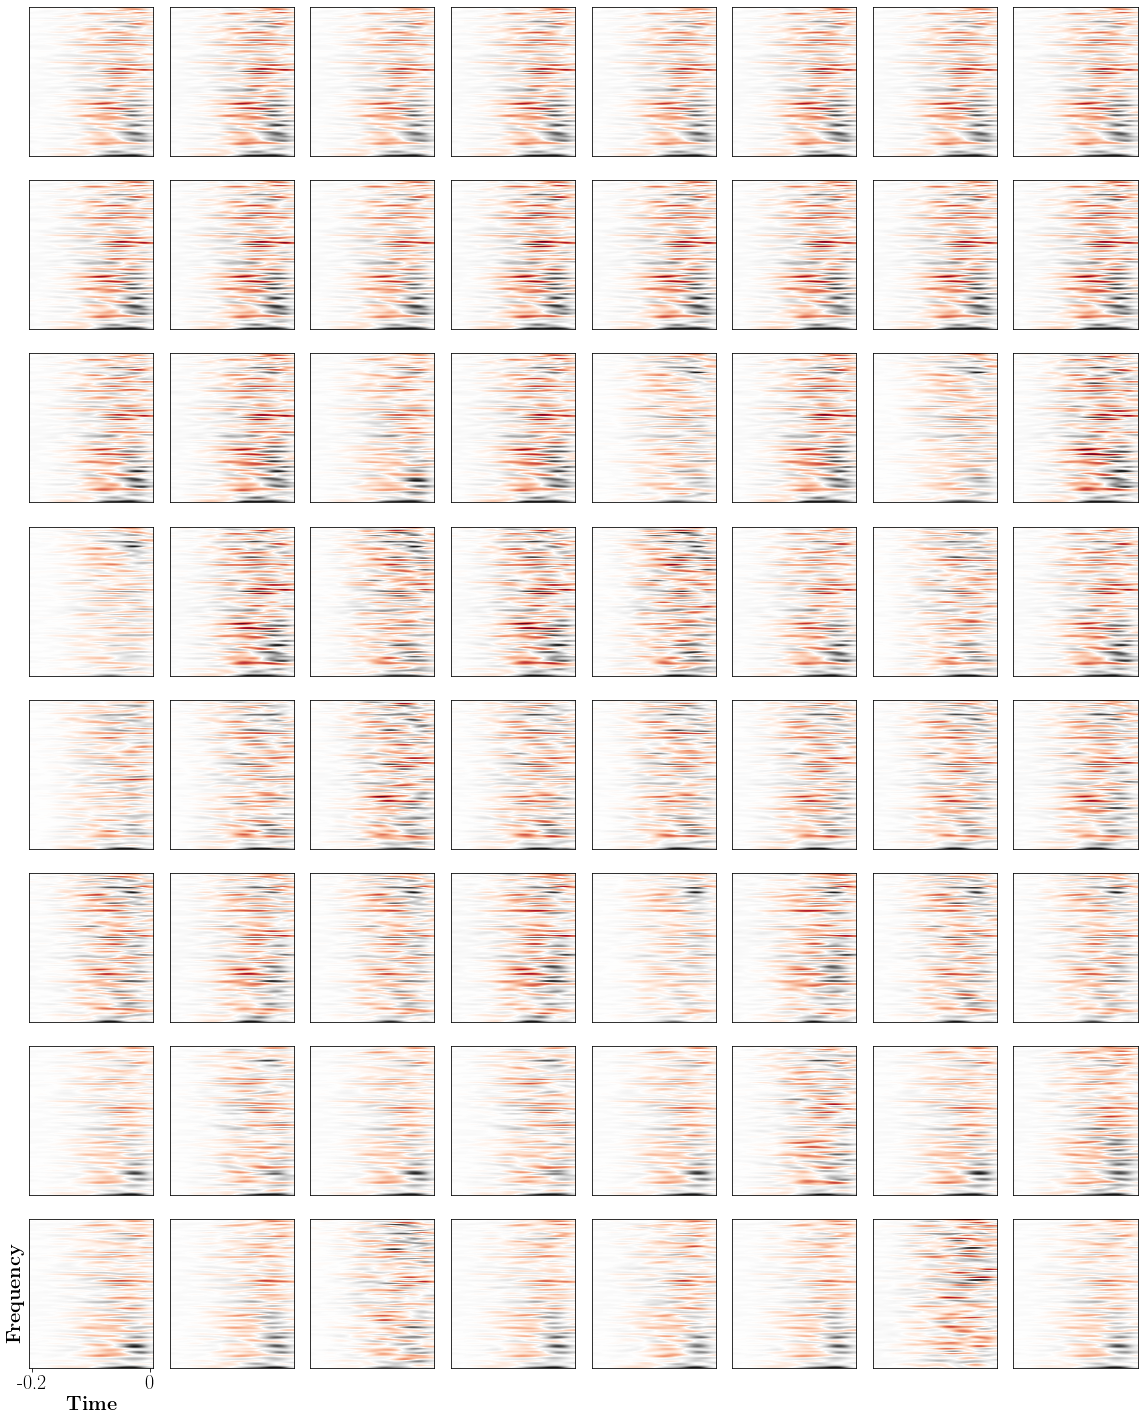

In [10]:
fig, axes = plt.subplots(8, 8, figsize=(16, 20))

for idx, ax in enumerate(axes.ravel()):
    bound = np.max([np.abs(np.max(strfs[idx])), np.abs(np.min(strfs[idx]))])
    ax.imshow(np.flip(strfs[idx], axis=1),
              cmap='RdGy',
              interpolation='spline36',
              vmin=-bound,
              vmax=bound)
    ax.set_aspect(0.25)
    ax.set_xticks([])
    ax.set_yticks([])
    
axes[-1, 0].set_ylabel(r'\textbf{Frequency}', fontsize=20)
axes[-1, 0].set_xlabel(r'\textbf{Time}', fontsize=20)
axes[-1, 0].tick_params(labelsize=20)
axes[-1, 0].set_xticks([0, 19])
axes[-1, 0].set_xticklabels([-0.2, 0])

plt.tight_layout()
# plt.savefig('ecog_strfs_matlab.pdf', bbox_inches='tight')

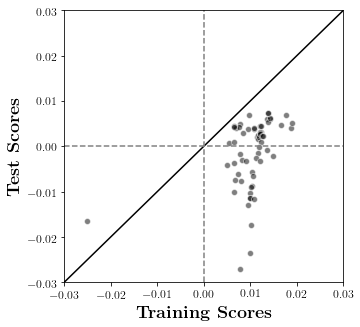

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.scatter(train_scores, test_scores, color='k', edgecolor='w', alpha=0.5)
ax.plot([-0.03, 0.03], [-0.03, 0.03], color='k')
ax.set_xlim([-0.03, 0.03])
ax.set_ylim([-0.03, 0.03])

ax.axhline(0, linestyle='--', color='gray')
ax.axvline(0, linestyle='--', color='gray')

ax.tick_params(labelsize=12)
ax.set_xlabel(r'\textbf{Training Scores}', fontsize=18)
ax.set_ylabel(r'\textbf{Test Scores}', fontsize=18)
plt.savefig('matlab_strf_scores.pdf', bbox_inches='tight')

In [11]:
n_train_samples_adj = train_stim.shape[0] - n_frames + 1
n_test_samples_adj = test_stim.shape[0] - n_frames + 1

In [12]:
electrode_idx = 0

X_train = np.zeros((n_train_samples_adj, n_features * n_frames))
y_true_train = train_resps[electrode_idx, 19:]

X_test = np.zeros((n_test_samples_adj, n_features * n_frames))
y_true_test = test_resps[electrode_idx, 19:]

In [13]:
for sample in range(n_train_samples_adj):
    X_train[sample] = np.flip(train_stim[sample:sample + n_frames], axis=0).ravel()
for sample in range(n_test_samples_adj):
    X_test[sample] = np.flip(test_stim[sample:sample + n_frames], axis=0).ravel()

In [14]:
y_train_alt = np.dot(X_train, strfs[electrode_idx].T.ravel())
y_test_alt = np.dot(X_test, strfs[electrode_idx].T.ravel())

In [15]:
r2_score(y_true_train, y_train_alt)

0.011513210111848249

In [16]:
r2_score(y_true_test, y_test_alt)

0.0021418508750566945

In [31]:
ols = LinearRegression(fit_intercept=False, normalize=False)
ols.fit(X_train, y_true_train)

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=False)

In [32]:
print(ols.score(X_train, y_true_train))
print(ols.score(X_test, y_true_test))

0.03017555782985426
-0.019103656992878415


In [33]:
ridge = RidgeCV(alphas=np.linspace(1e6, 3e6, 100),
                normalize=False,
                fit_intercept=False,
                cv=None).fit(X_train, y_true_train)

In [34]:
print(ridge.score(X_train, y_true_train))
print(ridge.score(X_test, y_true_test))

0.011770649170293024
0.003934285216723343


In [17]:
lasso = LassoCV(n_alphas=100,
                eps=0.0001,
                fit_intercept=False,
                normalize=False,
                cv=10).fit(X_train, y_true_train)

In [18]:
print(lasso.score(X_train, y_true_train))
print(lasso.score(X_test, y_true_test))

0.005286750320149802
0.0021582602500667125


In [19]:
lasso_strf_rect = lasso.coef_.reshape((20, 96)).T

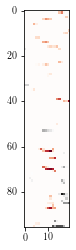

In [28]:
plt.imshow(np.flip(lasso_strf_rect, axis=1),
           cmap='RdGy',
           interpolation=None)

In [23]:
from scipy.ndimage import gaussian_filter

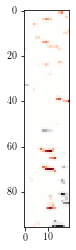

In [34]:
plt.imshow(np.flip(gaussian_filter(lasso_strf_rect, sigma=0.5), axis=1),
           cmap='RdGy',
           interpolation=None)


In [28]:
scipy.__version__

'1.2.1'

In [41]:
enet = ElasticNetCV(l1_ratio=np.array([0.0001, 0.001, 0.01, 0.1, 0.25]),
                    eps=0.01,
                    fit_intercept=False,
                    normalize=False,
                    cv=5).fit(X_train, y_true_train)

In [42]:
print(enet.score(X_train, y_true_train))
print(enet.score(X_test, y_true_test))

0.006835542314643783
0.0025167409341585456


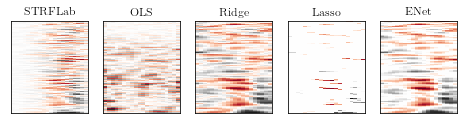

In [56]:
fig, axes = plt.subplots(1, 5, figsize=(8, 4))

fits = [ols, ridge, lasso, enet]
labels = ['STRFLab', 'OLS', 'Ridge', 'Lasso', 'ENet']

axes[0].imshow(np.flip(strfs[1], axis=1),
          cmap='RdGy',
          interpolation=None,
          vmin=-0.002,
          vmax=0.002)


for idx, ax in enumerate(axes[1:].ravel()):
    fit = fits[idx]
    coef = fit.coef_.reshape((20, 96)).T
    bound = np.max([np.abs(np.max(coef)), np.abs(np.min(coef))])
    ax.imshow(np.flip(coef, axis=1),
              cmap='RdGy',
              interpolation=None,
              vmin=-bound,
              vmax=bound)
    
for idx, ax in enumerate(axes.ravel()):
    ax.set_title(labels[idx], fontsize=12)
    ax.set_aspect(0.25)
    ax.set_xticks([])
    ax.set_yticks([])

plt.savefig('example_strfs.pdf', bbox_inches='tight')